In [1]:
import pickle
import os
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import altair as alt
from altair import datum

from dltools.cov.markup import compute

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
filename = "Data/Cov ang dist wo cos at the low int group; target=C1p,I2p,I1p.pickle"

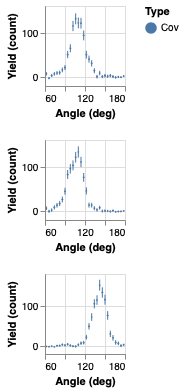

In [16]:
def binit(x):
    return x.groupby_bins("ang", range(0, 180+4, 4), right=False)


with open(filename, "rb") as fp:
    d = pickle.load(fp)

xkey, ykey = "ang", "h0h1angle"
n = d["N"]
dx = d["Sum[XYZ]"][xkey][1] - d["Sum[XYZ]"][xkey][0]
x = binit(d["Sum[XYZ]"][xkey] + dx / 2).mean()
y = binit(d["Sum[XYZ]"][ykey]).sum()
where = 0 < y

df01 = pd.concat([
    pd.DataFrame({
        "Angle (deg)": x[where],
        "Type": "Cov",
        "Name": "1st-2nd",
        "Yield (count)": binit(d["Cov[X,Y,Z]"][ykey] * n).sum()[where],
        "Std (count)": binit((d["Err[Cov[X,Y,Z]]"][ykey] * n) ** 2).sum()[where] ** 0.5,
    }),   
], ignore_index=True)

xkey, ykey = "ang", "h0h2angle"
n = d["N"]
dx = d["Sum[XYZ]"][xkey][1] - d["Sum[XYZ]"][xkey][0]
x = binit(d["Sum[XYZ]"][xkey] + dx / 2).mean()
y = binit(d["Sum[XYZ]"][ykey]).sum()
where = 0 < y

df02 = pd.concat([
    pd.DataFrame({
        "Angle (deg)": x[where],
        "Type": "Cov",
        "Name": "1st-3rd",
        "Yield (count)": binit(d["Cov[X,Y,Z]"][ykey] * n).sum()[where],
        "Std (count)": binit((d["Err[Cov[X,Y,Z]]"][ykey] * n) ** 2).sum()[where] ** 0.5,
    }),   
], ignore_index=True)

xkey, ykey = "ang", "h1h2angle"
n = d["N"]
dx = d["Sum[XYZ]"][xkey][1] - d["Sum[XYZ]"][xkey][0]
x = binit(d["Sum[XYZ]"][xkey] + dx / 2).mean()
y = binit(d["Sum[XYZ]"][ykey]).sum()
where = 0 < y

df12 = pd.concat([
    pd.DataFrame({
        "Angle (deg)": x[where],
        "Type": "Cov",
        "Name": "2nd-3rd",
        "Yield (count)": binit(d["Cov[X,Y,Z]"][ykey] * n).sum()[where],
        "Std (count)": binit((d["Err[Cov[X,Y,Z]]"][ykey] * n) ** 2).sum()[where] ** 0.5,
    }),   
], ignore_index=True)

df = pd.concat([df01, df02, df12], ignore_index=True)

base = alt.Chart(df, width=80, height=80).encode(
    alt.X(
        "Angle (deg)",
        scale=alt.Scale(domain=[60, 180], nice=False),
        axis=alt.Axis(tickCount=5, values=[60, 90, 120, 150, 180])
    ),
    y="Yield (count)", yError="Std (count)",
    color="Type",
)
fig = alt.vconcat()
for k in ["1st-2nd", "1st-3rd", "2nd-3rd"]:
    b = base.transform_filter(datum["Name"] == k)
    fig &= b.mark_errorbar(clip=True) + b.mark_point(clip=True, filled=True, size=4, opacity=1)
fig